## Model Architecture

The first model here is a multi-layer architecture consisting of alternating separable and normal convolutions and nonlinearities. These layers are followed by fully connected layers leading into a sigmoid. The model follows the architecture similar to VGG16 by K. Simonyan and A. Zisserman.

This model achieves a peak performance of about 94% accuracy within 11 minutes of training time on a GPU. It consists of 2,313,441 learnable parameters.

## Load libraries

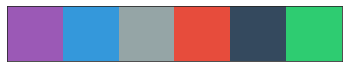

In [40]:
# Images
from PIL import Image
from skimage.io import imread
from skimage.transform import resize
import imgaug as aug
import imgaug.augmenters as imaug

# Toolbox
from pathlib import Path
import os
import numpy as np
import pandas as pd 
import seaborn as sns
import random
import sys
import matplotlib.pyplot as plt
%matplotlib inline

# Deep learning libraries
from keras.models import Model, Sequential
from keras.layers import Input, Dense, Flatten, Dropout, BatchNormalization
from keras.layers import Conv2D, SeparableConv2D, MaxPool2D, LeakyReLU, ReLU, Activation
from keras.optimizers import Adam, SGD, RMSprop
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
import tensorflow as tf
import cv2


# Evaluation libraries
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score, recall_score, precision_score, roc_auc_score, f1_score, accuracy_score
from sklearn.metrics import precision_recall_curve, auc
from mlxtend.plotting import plot_confusion_matrix

# Misc
import os
import warnings
warnings.filterwarnings(action='ignore')

# Preset data display
pd.options.display.max_seq_items = 1000
pd.options.display.max_rows =1000
pd.set_option('display.max_columns', 50)
pd.set_option('display.max_colwidth', 500)

# Set notebook colors and palette
flatui = ['#9b59b6', '#3498db', '#95a5a6', '#e74c3c', '#34495e', '#2ecc71']
sns.set_palette(flatui)
sns.palplot(sns.color_palette(flatui))
sns.set_style('white')
sns.set_color_codes(palette='deep')
# Favorite code to use: #34995e

# Setting seeds for reproducibility
seed = 100
np.random.seed(seed)
tf.set_random_seed(seed)

## Set directory

In [41]:
# Set directory
PATH = 'C:\\Users\\' + os.getlogin() + '\\Documents\\Programming\\DeepLearning\\07-pneunomia-radiograph-imaging\\images'
os.chdir(PATH)
os.getcwd()
os.listdir()

['gen_first_model', 'test', 'test_gen', 'train', 'train_gen', 'val', 'val_gen']

In [42]:
# Use Path
MAIN_PATH = Path(PATH)

# Path to train directory (Fancy pathlib...no more os.path!!)
train_dir = MAIN_PATH / 'train'

# Path to validation directory
val_dir = MAIN_PATH / 'val'

# Path to test directory
test_dir = MAIN_PATH / 'test'

## Training images

In [43]:
# Path to training images
normal_cases_dir = train_dir / 'NORMAL'
pneunomia_cases_dir = train_dir / 'PNEUMONIA'

# List of all images for training
normal_cases = normal_cases_dir.glob('*.jpeg')
pneumonia_cases = pneunomia_cases_dir.glob('*.jpeg')

# Create empty list to store the training data
train_data = []

# Loop through normal images and label = 0
for img in normal_cases:
    train_data.append((img, 0))
    
# Loop through pneunomia images and label = 1
for img in pneumonia_cases:
    train_data.append((img, 1))
    
# Create a dataframe
train_data = pd.DataFrame(train_data, columns=['image', 'label'], index=None)

# Shuffle
train_data = train_data.sample(frac=1).reset_index(drop=True)

## Testing images

In [44]:
# Path to testing images
normal_cases_dir = test_dir / 'NORMAL'
pneunomia_cases_dir = test_dir / 'PNEUMONIA'

# List of all images for training
normal_cases = normal_cases_dir.glob('*.jpeg')
pneumonia_cases = pneunomia_cases_dir.glob('*.jpeg')

# Create empty list to store the training data
test_data = []

# Loop through normal images and label = 0
for img in normal_cases:
    test_data.append((img, 0))
    
# Loop through pneunomia images and label = 1
for img in pneumonia_cases:
    test_data.append((img, 1))
    
# Create a dataframe
test_data = pd.DataFrame(test_data, columns=['image', 'label'], index=None)

# # Shuffle
# test_data = test_data.sample(frac=1).reset_index(drop=True)

Try out different ways from other kernels on pulling images to test speed/readability.

In [45]:
# Define model parameters
EPOCHS = 10
BATCH_SIZE = 64
TARGET_SIZE = 150

## Generating images

Keras allows for image augmentation. This is where we generate batches of image data with real time data augmentation. The data will be looped over in batches indefinitely. I also tested it out in one of my development notebooks [here](https://github.com/davidtnly/DeepLearning/blob/master/00-development/12-image-augment.ipynb).

[TensorFlow Keras ImageDataGenerator Doc](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator)

In [46]:
# Use ImageDataGenerator to feed into the network in batch sizes
train_datagen = ImageDataGenerator(
    rescale=1./255,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

test_datagen = ImageDataGenerator(
    rescale=1./255,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

# Set paths and parameters
train_gen_path = MAIN_PATH / 'train_gen'
test_gen_path = MAIN_PATH / 'test_gen'

# Set generation object path
train_gen = train_datagen.flow_from_directory(
    directory=train_dir,
    target_size=(TARGET_SIZE, TARGET_SIZE),
    class_mode='binary',
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=seed,
    save_to_dir=train_gen_path
)

test_gen = test_datagen.flow_from_directory(
    directory=test_dir,
    target_size=(TARGET_SIZE, TARGET_SIZE),
    class_mode='binary',
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=seed,
    save_to_dir=test_gen_path
)

Found 5216 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


## Get test data arrays

In [47]:
test_data_arrays = []
test_labels = []

# Loop through the test data
for num in range(test_data.image.count()):
    for img in test_data:
        # Read the image path and resize to (150, 150)
        img = plt.imread(test_data.iloc[num].image)
        img = cv2.resize(img, (TARGET_SIZE, TARGET_SIZE))
        # Convert to 3D and scale
        img = np.dstack([img, img, img])
        img = img.astype('float32') / 255
        label = test_data.iloc[num].label
        
        # Append to list
        test_data_arrays.append(img)
        test_labels.append(label)

# Convert to arrays
test_data_arrays = np.array(test_data_arrays)
test_labels = np.array(test_labels)

In [48]:
test_labels.sum()

780

## Modeling

In [49]:
# Build the neural network
def build_model():
    
    # Input layer
    inputs = Input(shape=(TARGET_SIZE, TARGET_SIZE, 3), name='input_layer')
    
    # First convolutional block
    x = Conv2D(filters=16, kernel_size=(3, 3), activation='relu', padding='same', name='conv1_1')(inputs)
    x = Conv2D(filters=16, kernel_size=(3, 3), activation='relu', padding='same', name='conv1_2')(x)
    x = MaxPool2D(pool_size=(2, 2), name='pool1_1')(x) # max pooling operation for spatial data
    
    # Second convolutional block
    x = SeparableConv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='same', name='conv2_1')(x)
    x = BatchNormalization(name='bn2_1')(x) # stabilizing the learning process; reduce internal covariate shifting
    x = SeparableConv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='same', name='conv2_2')(x)
    x = BatchNormalization(name='bn2_2')(x) 
    x = MaxPool2D(pool_size=(2, 2), name='pool2_1')(x)
    
    # Third convolutional block
    x = SeparableConv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same', name='conv3_1')(x)
    x = SeparableConv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same', name='conv3_2')(x)
    x = BatchNormalization(name='bn3_1')(x) 
    x = MaxPool2D(pool_size=(2, 2), name='pool3_1')(x)   
    
    # Fourth convolutional block
    x = SeparableConv2D(filters=128, kernel_size=(3, 3), activation='relu', padding='same', name='conv4_1')(x)
    x = SeparableConv2D(filters=128, kernel_size=(3, 3), activation='relu', padding='same', name='conv4_2')(x)
    x = BatchNormalization(name='bn4_1')(x) 
    x = MaxPool2D(pool_size=(2, 2), name='pool4_1')(x)
#     x = Dropout(rate=0.20, name='dropout4_1')(x) # prevent network from overfitting; probabilistically reduce the network capacity
    
    # Fifth convolutional block
    x = SeparableConv2D(filters=256, kernel_size=(3, 3), activation='relu', padding='same', name='conv5_1')(x)
    x = SeparableConv2D(filters=256, kernel_size=(3, 3), activation='relu', padding='same', name='conv5_2')(x)
    x = BatchNormalization(name='bn5_1')(x) 
    x = MaxPool2D(pool_size=(2, 2), name='pool5_1')(x)
#     x = Dropout(rate=0.20, name='dropout5_1')(x) 
    
    # Fully connected block
    x = Flatten(name='flatten6_1')(x)
    x = Dense(512, activation='relu', name='fc6_1')(x)
    x = Dropout(rate=0.7, name='dropout6_1')(x)
    x = Dense(128, activation='relu', name='fc6_2')(x)
    x = Dropout(rate=0.5, name='dropout6_2')(x)
    x = Dense(64, activation='relu', name='fc6_3')(x)
    x = Dropout(rate=0.3, name='dropout6_3')(x)
    
    # Output
    output = Dense(units=1, activation='sigmoid', name='output')(x) # 1 so fewer parameters and computation are needed
    
    # Define model
    model = Model(inputs=inputs, outputs=output)
    return model

In [50]:
model =  build_model()

## Compile the model

The primary use case is to automatically save checkpoints during and at the end of training. This way you can use a trained model without having to retrain it, or pick-up training where you left of—in case the training process was interrupted.

In [51]:
# Creating model and compiling
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Save weights
# checkpoint_path = '../model_2/best_weights-cp-{epoch:04d}.ckpt'
# checkpoint_dir = os.path.dirname(checkpoint_path)

checkpoint = ModelCheckpoint(
                             #filepath=checkpoint_path,
                             #period=5, # save every 5 epochs
                             filepath='best_weights_model_16.hdf5',
                             save_best_only=True,
                             save_weights_only=True)

# Callbacks - view internal states and statistics of the model during training
lr_reduce = ReduceLROnPlateau(monitor='val_loss',
                              factor=0.3,
                              patience=2,
                              verbose=2,
                              mode='max')

# Stop if model is not improving
early_stop = EarlyStopping(monitor='val_loss',
                           min_delta=0.1,
                           patience=1,
                           mode='min')

In [52]:
history = model.fit_generator(
    train_gen, 
    steps_per_epoch=train_gen.samples // BATCH_SIZE,
    epochs=1,
    validation_data=test_gen,
    validation_steps=test_gen.samples // BATCH_SIZE,
    callbacks=[checkpoint, lr_reduce] # early_stop
)

Epoch 1/1
81/81 [==============================] - 77s 945ms/step - loss: 0.3417 - acc: 0.8324 - val_loss: 0.6822 - val_acc: 0.7344
